The purpose of this notebook is to compute the points-in-cap-per-direction distribution that I described in the previous notebook, but for the actual PMT positions. I obtained the PMT positions in x, y, z and put them in the pmt_positions.csv file, which I'll read. Then, I'll reuse some of the code I wrote in the other notebooks to rescale their positions so that the radius of the sphere is 1, and plot their positions in a $\phi - \theta$ plot. Then I'll compute and plot the distribution and calculate some of its properties.

Cool, let's go!

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import csv

In [91]:
# Load the CSV file
data = np.genfromtxt('pmt_positions.csv', delimiter=',', skip_header=1)

I accidentally kept PMTs that I didn't want, rerun code to make csv file. Anyway, I want to compute all the vector lengths to see which ones are reasonable.

In [92]:
vector_lengths = np.linalg.norm(data, axis=1)
print(vector_lengths)

[8406.98104278 8401.79225567 8406.97712466 ... 8390.08113032 8387.98751197
 8389.30197096]


It seems like all the vector lengths are between 8399 and 8424, so these are pretty close to each other, as expected. I think we have more PMTs than expected but let's keep going. Rescale data so that everything is on a sphere of radius 1:

In [93]:
rescaled_data = data / vector_lengths[:, np.newaxis]

In [94]:
vector_lengths_rescaled = np.linalg.norm(rescaled_data, axis = 1)
print(vector_lengths_rescaled)

[1. 1. 1. ... 1. 1. 1.]


In [95]:
def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta = np.arccos(z / r)
    return r, phi, theta

def convert_points_to_spherical(points):
    points_set_polars = []
    for point in points:
        x = point[0]
        y = point[1]
        z = point[2]
        r, phi, theta = cartesian_to_spherical(x, y, z)
        points_set_polars.append((r, phi, theta))
    return points_set_polars

In [96]:
points_polars = convert_points_to_spherical(rescaled_data)

In [97]:
points_phi = np.zeros(len(points_polars))
points_theta = np.zeros(len(points_polars))

for i in range(len(points_polars)):
    points_phi[i] = points_polars[i][1]
    points_theta[i] = points_polars[i][2]

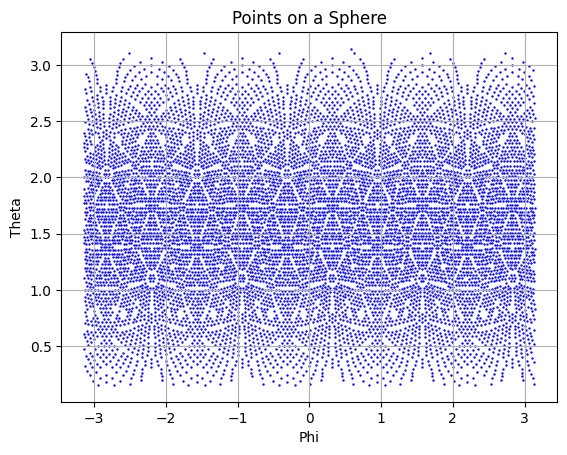

In [98]:
#Plot points on 2D map

plt.scatter(points_phi, points_theta, s = 0.5, color = 'blue', marker = 'o')

plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('Points on a Sphere')
plt.grid(True)

plt.savefig('PMTMap.pdf', format='pdf')
plt.show()

This looks just as I expected, which is great! Now we want the distributions. Will generate some random directions to begin with

In [99]:
def generate_random_numbers(m, n, count):
    return np.random.uniform(m, n, count)

In [100]:
def generate_points(N):
    x_array = generate_random_numbers(-1, 1, N)
    y_array = generate_random_numbers(-1, 1, N)
    z_array = generate_random_numbers(-1, 1, N)
    return x_array, y_array, z_array

In [101]:
#next three cells: make direction (vector u) arrays

grid_size_1d_2 = 2400

In [102]:
x_array_2, y_array_2, z_array_2 = generate_points(grid_size_1d_2)

In [103]:
points_set_2 = []


for i in range(grid_size_1d_2):
    vector_length = (x_array_2[i]**2 + y_array_2[i]**2 + z_array_2[i]**2)**(1/2)
    
    if vector_length <= 1:
        points_set_2.append(np.array([x_array_2[i] / vector_length, y_array_2[i] / vector_length, z_array_2[i] / vector_length]))

points_set_2 = np.array(points_set_2)
print(points_set_2)        

print(len(points_set_2))

[[ 0.27743193  0.20233116 -0.9391984 ]
 [ 0.28821416  0.85410345  0.43294329]
 [ 0.94385007 -0.31738484 -0.09172739]
 ...
 [-0.86715307  0.1920883  -0.45950803]
 [ 0.25993585  0.44998097 -0.8543714 ]
 [-0.34065425 -0.69387977  0.63441748]]
1243


In [104]:
points_set_polars_2 = convert_points_to_spherical(points_set_2)

In [105]:
#convert u arrays to spherical polars as well

points_phi_2 = np.zeros(len(points_set_polars_2))
points_theta_2 = np.zeros(len(points_set_polars_2))

for i in range(len(points_set_polars_2)):
    points_phi_2[i] = points_set_polars_2[i][1]
    points_theta_2[i] = points_set_polars_2[i][2]

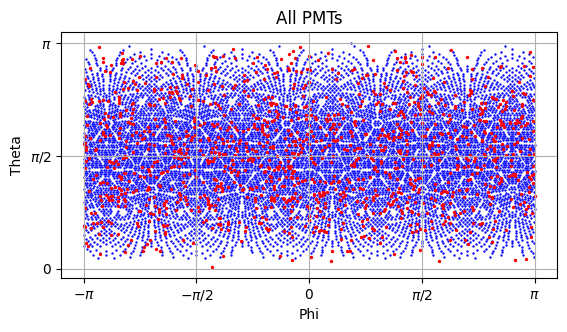

In [106]:
# Plot the grid points
plt.scatter(points_phi, points_theta, s=0.5, color='blue')  # Adjust marker size and color as needed
plt.scatter(points_phi_2, points_theta_2, s=2, color='red')

# Set x-axis ticks
plt.xticks(np.linspace(-np.pi, np.pi, 5), 
           ['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])

# Set y-axis ticks
plt.yticks(np.linspace(0, np.pi, 3), 
           ['$0$', '$\pi/2$', '$\pi$'])

plt.xlabel('Phi')
plt.ylabel('Theta')
plt.title('All PMTs')

# Set aspect ratio to 'equal'
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig('PMTMapWithDirections.pdf', format='pdf')

plt.grid(True)
plt.show()


In [107]:
#function that computes the angle between two vectors

def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    cosine_angle = dot_product / (magnitude_v1 * magnitude_v2)
    angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return angle_rad

In [108]:
points_in_cap_per_grid_point = np.zeros(len(points_set_2))

In [109]:
for i in range(len(points_set_2)): #for each directions
    
    counter = 0
    
    for j in range(len(rescaled_data)): #for each of the N points
        angle = angle_between_vectors(points_set_2[i], rescaled_data[j])
        if angle < np.pi/4:
            counter += 1
    print('computed for i = '+str(i)+' out of '+str(len(points_set_2)))
            
    points_in_cap_per_grid_point[i] = counter

computed for i = 0 out of 1243
computed for i = 1 out of 1243
computed for i = 2 out of 1243
computed for i = 3 out of 1243
computed for i = 4 out of 1243
computed for i = 5 out of 1243
computed for i = 6 out of 1243
computed for i = 7 out of 1243
computed for i = 8 out of 1243
computed for i = 9 out of 1243
computed for i = 10 out of 1243
computed for i = 11 out of 1243
computed for i = 12 out of 1243
computed for i = 13 out of 1243
computed for i = 14 out of 1243
computed for i = 15 out of 1243
computed for i = 16 out of 1243
computed for i = 17 out of 1243
computed for i = 18 out of 1243
computed for i = 19 out of 1243
computed for i = 20 out of 1243
computed for i = 21 out of 1243
computed for i = 22 out of 1243
computed for i = 23 out of 1243
computed for i = 24 out of 1243
computed for i = 25 out of 1243
computed for i = 26 out of 1243
computed for i = 27 out of 1243
computed for i = 28 out of 1243
computed for i = 29 out of 1243
computed for i = 30 out of 1243
computed for i = 3

In [110]:
points_in_cap_per_grid_point_PiOver3 = np.zeros(len(points_set_2))

for i in range(len(points_set_2)): #for each directions
    
    counter = 0
    
    for j in range(len(rescaled_data)): #for each of the N points
        angle = angle_between_vectors(points_set_2[i], rescaled_data[j])
        if angle < np.pi/3:
            counter += 1
    print('computed for i = '+str(i)+' out of '+str(len(points_set_2)))
            
    points_in_cap_per_grid_point_PiOver3[i] = counter

computed for i = 0 out of 1243
computed for i = 1 out of 1243
computed for i = 2 out of 1243
computed for i = 3 out of 1243
computed for i = 4 out of 1243
computed for i = 5 out of 1243
computed for i = 6 out of 1243
computed for i = 7 out of 1243
computed for i = 8 out of 1243
computed for i = 9 out of 1243
computed for i = 10 out of 1243
computed for i = 11 out of 1243
computed for i = 12 out of 1243
computed for i = 13 out of 1243
computed for i = 14 out of 1243
computed for i = 15 out of 1243
computed for i = 16 out of 1243
computed for i = 17 out of 1243
computed for i = 18 out of 1243
computed for i = 19 out of 1243
computed for i = 20 out of 1243
computed for i = 21 out of 1243
computed for i = 22 out of 1243
computed for i = 23 out of 1243
computed for i = 24 out of 1243
computed for i = 25 out of 1243
computed for i = 26 out of 1243
computed for i = 27 out of 1243
computed for i = 28 out of 1243
computed for i = 29 out of 1243
computed for i = 30 out of 1243
computed for i = 3

In [111]:
points_in_cap_per_grid_point_PiOver6 = np.zeros(len(points_set_2))

for i in range(len(points_set_2)): #for each directions
    
    counter = 0
    
    for j in range(len(rescaled_data)): #for each of the N points
        angle = angle_between_vectors(points_set_2[i], rescaled_data[j])
        if angle < np.pi/6:
            counter += 1
    print('computed for i = '+str(i)+' out of '+str(len(points_set_2)))
            
    points_in_cap_per_grid_point_PiOver6[i] = counter

computed for i = 0 out of 1243
computed for i = 1 out of 1243
computed for i = 2 out of 1243
computed for i = 3 out of 1243
computed for i = 4 out of 1243
computed for i = 5 out of 1243
computed for i = 6 out of 1243
computed for i = 7 out of 1243
computed for i = 8 out of 1243
computed for i = 9 out of 1243
computed for i = 10 out of 1243
computed for i = 11 out of 1243
computed for i = 12 out of 1243
computed for i = 13 out of 1243
computed for i = 14 out of 1243
computed for i = 15 out of 1243
computed for i = 16 out of 1243
computed for i = 17 out of 1243
computed for i = 18 out of 1243
computed for i = 19 out of 1243
computed for i = 20 out of 1243
computed for i = 21 out of 1243
computed for i = 22 out of 1243
computed for i = 23 out of 1243
computed for i = 24 out of 1243
computed for i = 25 out of 1243
computed for i = 26 out of 1243
computed for i = 27 out of 1243
computed for i = 28 out of 1243
computed for i = 29 out of 1243
computed for i = 30 out of 1243
computed for i = 3

They all seem to have one big peak, and one smaller peak to the left of the big peak. Check if values of the big peak centered around expected value. From other notebooks: For an isotropic distribution of the N points on the sphere, we expect this to be sharply peaked around $N \cdot \frac{A_{cap}}{A_{sphere}}$. 

We know that $N = 9389$ (the number of PMTs). The area of the sphere is $A_{sphere} = 4 \pi r^2 = 4\pi$ (because the radius is 1). The area of the cap is $A_{cap} = 2 \pi r^2 (1 - \mathrm{cos}\alpha) = 2 \pi (1 - \mathrm{cos} \alpha)$, so the peak should be around:

$$N \cdot \frac{A_{cap}}{A_{sphere}} = N \cdot \frac{2 \pi (1 - \mathrm{cos} \alpha)}{4\pi} = N \cdot \frac{1 - \mathrm{cos} \alpha}{2}$$

In [112]:
# calculate peaks

def peak_value(N, alpha):
    return N * (1 - np.cos(alpha))/2

In [113]:
N = 9389

In [114]:
peak_PiOver3 = peak_value(N, np.pi/3)
print("peak should be at "+str(peak_PiOver3)+" for alpha = pi/3")
peak_PiOver4 = peak_value(N, np.pi/4)
print("peak should be at "+str(peak_PiOver4)+" for alpha = pi/4")
peak_PiOver6 = peak_value(N, np.pi/6)
print("peak should be at "+str(peak_PiOver6)+" for alpha = pi/6")

peak should be at 2347.2499999999995 for alpha = pi/3
peak should be at 1374.9872157197524 for alpha = pi/4
peak should be at 628.9437419339525 for alpha = pi/6


Remake plots:

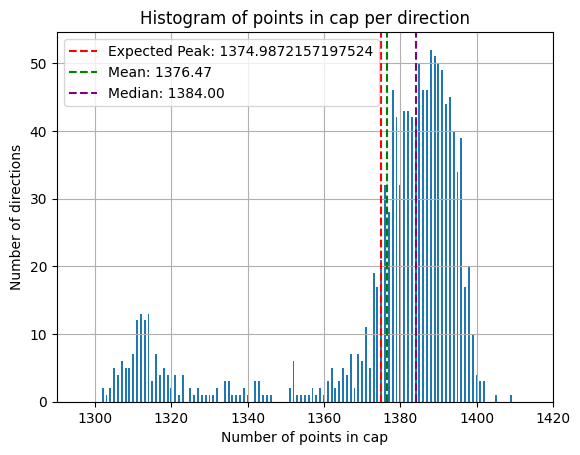

In [115]:
# Compute histogram
hist_values_PiOver4, bin_edges_PiOver4 = np.histogram(points_in_cap_per_grid_point, bins=np.arange(points_in_cap_per_grid_point.max() + 2))

# Plot histogram
plt.bar(bin_edges_PiOver4[:-1], hist_values_PiOver4, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.xlim(1290, 1420)
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

plt.axvline(x=peak_PiOver4, color='red', linestyle='--', label='Expected Peak: {}'.format(peak_PiOver4))

# Compute mean and median
mean_value = np.mean(points_in_cap_per_grid_point)
median_value = np.median(points_in_cap_per_grid_point)

# Plot mean and median as vertical lines
plt.axvline(x=mean_value, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean_value))
plt.axvline(x=median_value, color='purple', linestyle='--', label='Median: {:.2f}'.format(median_value))

# Add legend
plt.legend()

plt.savefig("RandomGridTruePMTs_PiOver4.pdf", format='pdf')
plt.show()


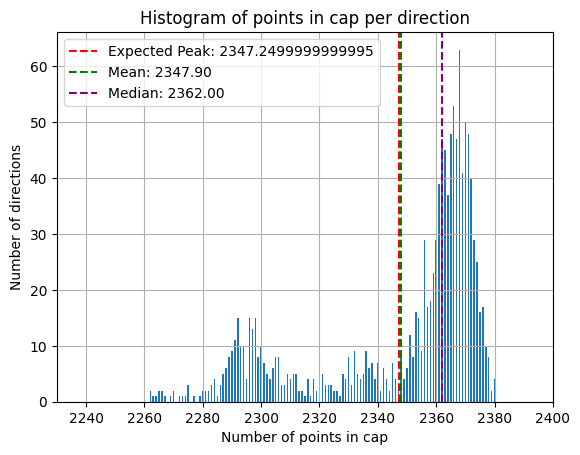

In [116]:
# Compute histogram
hist_values_PiOver3, bin_edges_PiOver3 = np.histogram(points_in_cap_per_grid_point_PiOver3, bins=np.arange(points_in_cap_per_grid_point_PiOver3.max() + 2))

# Plot histogram
plt.bar(bin_edges_PiOver3[:-1], hist_values_PiOver3, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.xlim(2230, 2400)
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

plt.axvline(x=peak_PiOver3, color='red', linestyle='--', label='Expected Peak: {}'.format(peak_PiOver3))

# Compute mean and median
mean_value_PiOver3 = np.mean(points_in_cap_per_grid_point_PiOver3)
median_value_PiOver3 = np.median(points_in_cap_per_grid_point_PiOver3)

# Plot mean and median as vertical lines
plt.axvline(x=mean_value_PiOver3, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean_value_PiOver3))
plt.axvline(x=median_value_PiOver3, color='purple', linestyle='--', label='Median: {:.2f}'.format(median_value_PiOver3))

# Add legend
plt.legend()

plt.savefig("RandomGridTruePMTs_PiOver3.pdf", format='pdf')
plt.show()


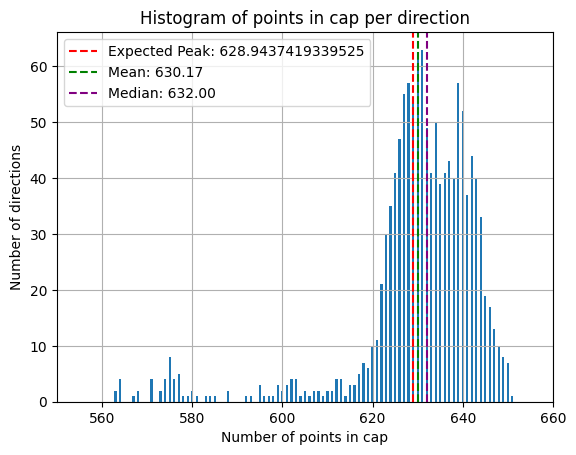

In [117]:
# Compute histogram
hist_values_PiOver6, bin_edges_PiOver6 = np.histogram(points_in_cap_per_grid_point_PiOver6, bins=np.arange(points_in_cap_per_grid_point_PiOver6.max() + 2))

# Plot histogram
plt.bar(bin_edges_PiOver6[:-1], hist_values_PiOver6, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.xlim(550, 660)
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

plt.axvline(x=peak_PiOver6, color='red', linestyle='--', label='Expected Peak: {}'.format(peak_PiOver6))

# Compute mean and median
mean_value_PiOver6 = np.mean(points_in_cap_per_grid_point_PiOver6)
median_value_PiOver6 = np.median(points_in_cap_per_grid_point_PiOver6)

# Plot mean and median as vertical lines
plt.axvline(x=mean_value_PiOver6, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean_value_PiOver6))
plt.axvline(x=median_value_PiOver6, color='purple', linestyle='--', label='Median: {:.2f}'.format(median_value_PiOver6))

# Add legend
plt.legend()

plt.savefig("RandomGridTruePMTs_PiOvr6.pdf", format='pdf')
plt.show()


Now plot the same distributions for 400 PMTs missing in one place (big gap) -- see PMTMapWithGap to check what the map looks like

In [118]:
gappy_points_phi = points_phi[400:]
gappy_points_theta = points_theta[400:]
gappy_rescaled_data = rescaled_data[400:]

In [119]:
for i in range(len(points_set_2)): #for each directions
    
    counter = 0
    
    for j in range(len(gappy_rescaled_data)): #for each of the N points
        angle = angle_between_vectors(points_set_2[i], gappy_rescaled_data[j])
        if angle < np.pi/4:
            counter += 1
    print('computed for i = '+str(i)+' out of '+str(len(points_set_2)))
            
    points_in_cap_per_grid_point[i] = counter

computed for i = 0 out of 1243
computed for i = 1 out of 1243
computed for i = 2 out of 1243
computed for i = 3 out of 1243
computed for i = 4 out of 1243
computed for i = 5 out of 1243
computed for i = 6 out of 1243
computed for i = 7 out of 1243
computed for i = 8 out of 1243
computed for i = 9 out of 1243
computed for i = 10 out of 1243
computed for i = 11 out of 1243
computed for i = 12 out of 1243
computed for i = 13 out of 1243
computed for i = 14 out of 1243
computed for i = 15 out of 1243
computed for i = 16 out of 1243
computed for i = 17 out of 1243
computed for i = 18 out of 1243
computed for i = 19 out of 1243
computed for i = 20 out of 1243
computed for i = 21 out of 1243
computed for i = 22 out of 1243
computed for i = 23 out of 1243
computed for i = 24 out of 1243
computed for i = 25 out of 1243
computed for i = 26 out of 1243
computed for i = 27 out of 1243
computed for i = 28 out of 1243
computed for i = 29 out of 1243
computed for i = 30 out of 1243
computed for i = 3

In [120]:
points_in_cap_per_grid_point_PiOver3 = np.zeros(len(points_set_2))

for i in range(len(points_set_2)): #for each directions
    
    counter = 0
    
    for j in range(len(gappy_rescaled_data)): #for each of the N points
        angle = angle_between_vectors(points_set_2[i], gappy_rescaled_data[j])
        if angle < np.pi/3:
            counter += 1
    print('computed for i = '+str(i)+' out of '+str(len(points_set_2)))
            
    points_in_cap_per_grid_point_PiOver3[i] = counter

computed for i = 0 out of 1243
computed for i = 1 out of 1243
computed for i = 2 out of 1243
computed for i = 3 out of 1243
computed for i = 4 out of 1243
computed for i = 5 out of 1243
computed for i = 6 out of 1243
computed for i = 7 out of 1243
computed for i = 8 out of 1243
computed for i = 9 out of 1243
computed for i = 10 out of 1243
computed for i = 11 out of 1243
computed for i = 12 out of 1243
computed for i = 13 out of 1243
computed for i = 14 out of 1243
computed for i = 15 out of 1243
computed for i = 16 out of 1243
computed for i = 17 out of 1243
computed for i = 18 out of 1243
computed for i = 19 out of 1243
computed for i = 20 out of 1243
computed for i = 21 out of 1243
computed for i = 22 out of 1243
computed for i = 23 out of 1243
computed for i = 24 out of 1243
computed for i = 25 out of 1243
computed for i = 26 out of 1243
computed for i = 27 out of 1243
computed for i = 28 out of 1243
computed for i = 29 out of 1243
computed for i = 30 out of 1243
computed for i = 3

In [121]:
points_in_cap_per_grid_point_PiOver6 = np.zeros(len(points_set_2))

for i in range(len(points_set_2)): #for each directions
    
    counter = 0
    
    for j in range(len(gappy_rescaled_data)): #for each of the N points
        angle = angle_between_vectors(points_set_2[i], gappy_rescaled_data[j])
        if angle < np.pi/6:
            counter += 1
    print('computed for i = '+str(i)+' out of '+str(len(points_set_2)))
            
    points_in_cap_per_grid_point_PiOver6[i] = counter

computed for i = 0 out of 1243
computed for i = 1 out of 1243
computed for i = 2 out of 1243
computed for i = 3 out of 1243
computed for i = 4 out of 1243
computed for i = 5 out of 1243
computed for i = 6 out of 1243
computed for i = 7 out of 1243
computed for i = 8 out of 1243
computed for i = 9 out of 1243
computed for i = 10 out of 1243
computed for i = 11 out of 1243
computed for i = 12 out of 1243
computed for i = 13 out of 1243
computed for i = 14 out of 1243
computed for i = 15 out of 1243
computed for i = 16 out of 1243
computed for i = 17 out of 1243
computed for i = 18 out of 1243
computed for i = 19 out of 1243
computed for i = 20 out of 1243
computed for i = 21 out of 1243
computed for i = 22 out of 1243
computed for i = 23 out of 1243
computed for i = 24 out of 1243
computed for i = 25 out of 1243
computed for i = 26 out of 1243
computed for i = 27 out of 1243
computed for i = 28 out of 1243
computed for i = 29 out of 1243
computed for i = 30 out of 1243
computed for i = 3

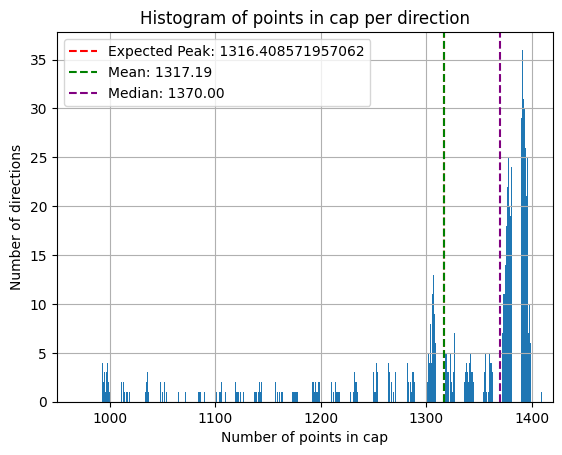

In [122]:
# Compute histogram
hist_values_PiOver4, bin_edges_PiOver4 = np.histogram(points_in_cap_per_grid_point, bins=np.arange(points_in_cap_per_grid_point.max() + 2))

# Plot histogram
plt.bar(bin_edges_PiOver4[:-1], hist_values_PiOver4, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.xlim(950, 1420)
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

#scale expected number by (no PMTs)/(total no PMTs)
plt.axvline(x=peak_PiOver4*(N-400)/N, color='red', linestyle='--', label='Expected Peak: {}'.format(peak_PiOver4*(N-400)/N))

# Compute mean and median
mean_value = np.mean(points_in_cap_per_grid_point)
median_value = np.median(points_in_cap_per_grid_point)

# Plot mean and median as vertical lines
plt.axvline(x=mean_value, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean_value))
plt.axvline(x=median_value, color='purple', linestyle='--', label='Median: {:.2f}'.format(median_value))

# Add legend
plt.legend()

plt.savefig("RandomGridPMTsWithGap_PiOver4.pdf", format='pdf')
plt.show()


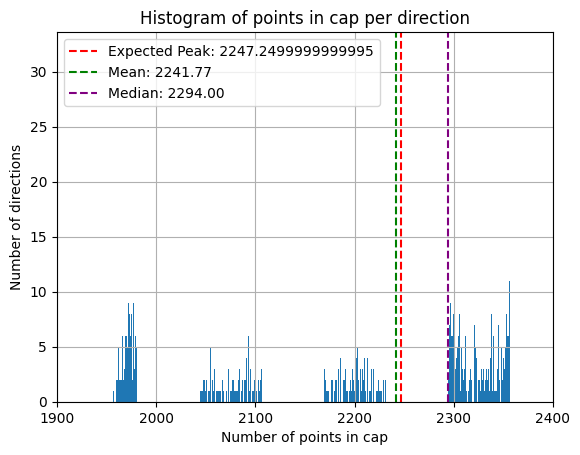

In [123]:
# Compute histogram
hist_values_PiOver3, bin_edges_PiOver3 = np.histogram(points_in_cap_per_grid_point_PiOver3, bins=np.arange(points_in_cap_per_grid_point_PiOver3.max() + 2))

# Plot histogram
plt.bar(bin_edges_PiOver3[:-1], hist_values_PiOver3, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.xlim(1900, 2400)
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

plt.axvline(x=peak_PiOver3*(N-400)/N, color='red', linestyle='--', label='Expected Peak: {}'.format(peak_PiOver3*(N-400)/N))

# Compute mean and median
mean_value_PiOver3 = np.mean(points_in_cap_per_grid_point_PiOver3)
median_value_PiOver3 = np.median(points_in_cap_per_grid_point_PiOver3)

# Plot mean and median as vertical lines
plt.axvline(x=mean_value_PiOver3, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean_value_PiOver3))
plt.axvline(x=median_value_PiOver3, color='purple', linestyle='--', label='Median: {:.2f}'.format(median_value_PiOver3))

# Add legend
plt.legend()

plt.savefig("RandomGridPMTsWithGap_PiOver3.pdf", format='pdf')
plt.show()


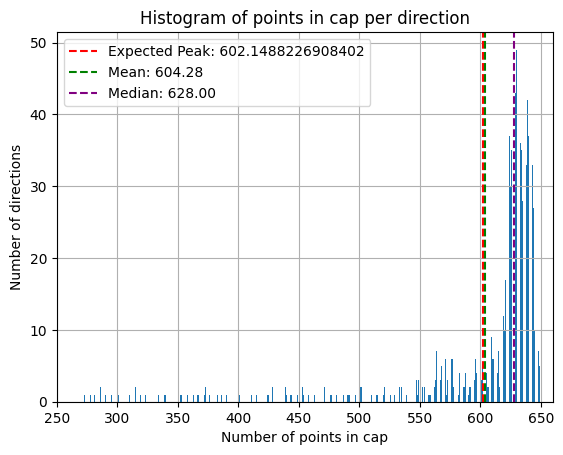

In [124]:
# Compute histogram
hist_values_PiOver6, bin_edges_PiOver6 = np.histogram(points_in_cap_per_grid_point_PiOver6, bins=np.arange(points_in_cap_per_grid_point_PiOver6.max() + 2))

# Plot histogram
plt.bar(bin_edges_PiOver6[:-1], hist_values_PiOver6, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.xlim(250, 660)
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

plt.axvline(x=peak_PiOver6*(N-400)/N, color='red', linestyle='--', label='Expected Peak: {}'.format(peak_PiOver6*(N-400)/N))

# Compute mean and median
mean_value_PiOver6 = np.mean(points_in_cap_per_grid_point_PiOver6)
median_value_PiOver6 = np.median(points_in_cap_per_grid_point_PiOver6)

# Plot mean and median as vertical lines
plt.axvline(x=mean_value_PiOver6, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean_value_PiOver6))
plt.axvline(x=median_value_PiOver6, color='purple', linestyle='--', label='Median: {:.2f}'.format(median_value_PiOver6))

# Add legend
plt.legend()

plt.savefig("RandomGridPMTsWithGap_PiOvr6.pdf", format='pdf')
plt.show()

In [125]:
peak_PiOver8 = peak_value(N, np.pi/8)
print("peak should be at "+str(peak_PiOver8)+" for alpha = pi/8")

peak should be at 357.3475346257644 for alpha = pi/8


In [129]:
points_in_cap_per_grid_point_PiOver8 = np.zeros(len(points_set_2))

for i in range(len(points_set_2)): #for each directions
    
    counter = 0
    
    for j in range(len(gappy_rescaled_data)): #for each of the N points
        angle = angle_between_vectors(points_set_2[i], gappy_rescaled_data[j])
        if angle < np.pi/8:
            counter += 1
    print('computed for i = '+str(i)+' out of '+str(len(points_set_2)))
            
    points_in_cap_per_grid_point_PiOver8[i] = counter

computed for i = 0 out of 1243
computed for i = 1 out of 1243
computed for i = 2 out of 1243
computed for i = 3 out of 1243
computed for i = 4 out of 1243
computed for i = 5 out of 1243
computed for i = 6 out of 1243
computed for i = 7 out of 1243
computed for i = 8 out of 1243
computed for i = 9 out of 1243
computed for i = 10 out of 1243
computed for i = 11 out of 1243
computed for i = 12 out of 1243
computed for i = 13 out of 1243
computed for i = 14 out of 1243
computed for i = 15 out of 1243
computed for i = 16 out of 1243
computed for i = 17 out of 1243
computed for i = 18 out of 1243
computed for i = 19 out of 1243
computed for i = 20 out of 1243
computed for i = 21 out of 1243
computed for i = 22 out of 1243
computed for i = 23 out of 1243
computed for i = 24 out of 1243
computed for i = 25 out of 1243
computed for i = 26 out of 1243
computed for i = 27 out of 1243
computed for i = 28 out of 1243
computed for i = 29 out of 1243
computed for i = 30 out of 1243
computed for i = 3

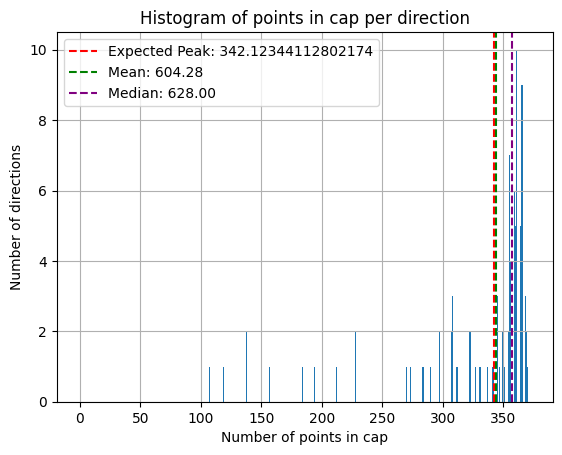

In [130]:
# Compute histogram
hist_values_PiOver8, bin_edges_PiOver8 = np.histogram(points_in_cap_per_grid_point_PiOver6, bins=np.arange(points_in_cap_per_grid_point_PiOver8.max() + 2))

# Plot histogram
plt.bar(bin_edges_PiOver8[:-1], hist_values_PiOver8, width=0.5, align='center')

plt.xlabel('Number of points in cap')
#plt.xlim(250, 660)
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

plt.axvline(x=peak_PiOver8*(N-400)/N, color='red', linestyle='--', label='Expected Peak: {}'.format(peak_PiOver8*(N-400)/N))

# Compute mean and median
mean_value_PiOver8 = np.mean(points_in_cap_per_grid_point_PiOver8)
median_value_PiOver8 = np.median(points_in_cap_per_grid_point_PiOver8)

# Plot mean and median as vertical lines
plt.axvline(x=mean_value_PiOver8, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean_value_PiOver6))
plt.axvline(x=median_value_PiOver8, color='purple', linestyle='--', label='Median: {:.2f}'.format(median_value_PiOver6))

# Add legend
plt.legend()

plt.savefig("RandomGridPMTsWithGap_PiOver8.pdf", format='pdf')
plt.show()

In [131]:
points_in_cap_per_grid_point_PiOver8 = np.zeros(len(points_set_2))

for i in range(len(points_set_2)): #for each directions
    
    counter = 0
    
    for j in range(len(rescaled_data)): #for each of the N points
        angle = angle_between_vectors(points_set_2[i], rescaled_data[j])
        if angle < np.pi/8:
            counter += 1
    print('computed for i = '+str(i)+' out of '+str(len(points_set_2)))
            
    points_in_cap_per_grid_point_PiOver8[i] = counter

computed for i = 0 out of 1243
computed for i = 1 out of 1243
computed for i = 2 out of 1243
computed for i = 3 out of 1243
computed for i = 4 out of 1243
computed for i = 5 out of 1243
computed for i = 6 out of 1243
computed for i = 7 out of 1243
computed for i = 8 out of 1243
computed for i = 9 out of 1243
computed for i = 10 out of 1243
computed for i = 11 out of 1243
computed for i = 12 out of 1243
computed for i = 13 out of 1243
computed for i = 14 out of 1243
computed for i = 15 out of 1243
computed for i = 16 out of 1243
computed for i = 17 out of 1243
computed for i = 18 out of 1243
computed for i = 19 out of 1243
computed for i = 20 out of 1243
computed for i = 21 out of 1243
computed for i = 22 out of 1243
computed for i = 23 out of 1243
computed for i = 24 out of 1243
computed for i = 25 out of 1243
computed for i = 26 out of 1243
computed for i = 27 out of 1243
computed for i = 28 out of 1243
computed for i = 29 out of 1243
computed for i = 30 out of 1243
computed for i = 3

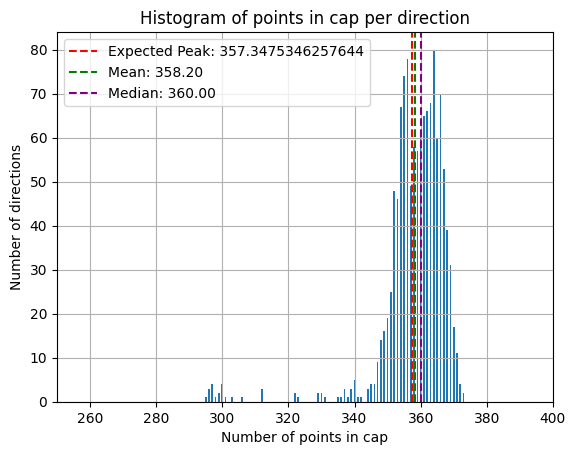

In [139]:
# Compute histogram
hist_values_PiOver8, bin_edges_PiOver8 = np.histogram(points_in_cap_per_grid_point_PiOver8, bins=np.arange(points_in_cap_per_grid_point_PiOver8.max() + 2))

# Plot histogram
plt.bar(bin_edges_PiOver8[:-1], hist_values_PiOver8, width=0.5, align='center')

plt.xlabel('Number of points in cap')
plt.xlim(250, 400)
plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

plt.axvline(x=peak_PiOver8, color='red', linestyle='--', label='Expected Peak: {}'.format(peak_PiOver8))

# Compute mean and median
mean_value_PiOver8 = np.mean(points_in_cap_per_grid_point_PiOver8)
median_value_PiOver8 = np.median(points_in_cap_per_grid_point_PiOver8)

# Plot mean and median as vertical lines
plt.axvline(x=mean_value_PiOver8, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean_value_PiOver8))
plt.axvline(x=median_value_PiOver8, color='purple', linestyle='--', label='Median: {:.2f}'.format(median_value_PiOver8))

# Add legend
plt.legend()

plt.savefig("RandomGridTruePMTs_PiOver8.pdf", format='pdf')
plt.show()
